<a href="https://colab.research.google.com/github/ValenzuelaDiego/proyectoInteligenciaArtificial/blob/main/Cartpole_DV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
try:
    from google.colab import drive
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: using Google CoLab


In [19]:
if COLAB:
  !sudo apt-get install -y xvfb ffmpeg x11-utils
  !pip install -q 'gym==0.17.0'
  !pip install -q 'imageio==2.4.0'
  !pip install -q PILLOW
  !pip install -q 'pyglet==1.5.0'
  !pip install -q pyvirtualdisplay
  !pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.9).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.



## DQN (Deep Q Learning) aplicado al Cart-Pole

A cart is connected to a hinged rigid pole.  The cart is free to move only in the vertical plane of the cart/track.  The agent can apply an implusive "left" or "right" force F of a fixed magnitude to the cart at discrete time intervals.  The cart-pole environment simulates the physics behind keeping the pole in a reasonably upright position on the cart.  The environment has four state variables:
Un carro esta conectado a un poste rigido. El carro es libre de moverse solamente en el plano vertical de la pista. El agente puede aplicar un impulso de fuerza F a la derecha o a la izquierda del carro. El objetivo es mantener el poste rigido de manera vertical. El ambiente tiene cuatro variables de estado: 

* $x$  La posición del carro en el circuito.
* $\theta$ El ángulo del poste respecto a la vertical.
* $\dot{x}$  Velocidad del carro.
* $\dot{\theta}$ La taza de cambio del ángulo del poste respecto a la vertical.

El espacio de acciones consisten en 2 acciones discretas:
* Aplicar fuerza a la izquierda
* Aplicar fuerza a la derecha

Para aplicar DQN a este problema, es necesario crear los siguientes componentes para los TF-Agents.

* Environment (Ambiente)
* Agent (Agente)
* Policies (Politicas)
* Metrics and Evaluation (Metricas y Evaluacion)
* Replay Buffer (Bufer de Reproducción)
* Data Collection (Conjunto de Datos)
* Training (Entrenamiento)

In [20]:
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [21]:
#Configuración de una pantalla virtual para renderizar entornos de gimnasio OpenAI
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Hiperparametros

Es necesario definir ciertos hiperparametros para el entorno CartPole

In [22]:
# Que tanto queremos entrenar?
num_iterations = 20000 
#Cuantos randoms steps inciales, antes de empezar a entrenar, 
#para poder recolectar data.
initial_collect_steps = 1000   
#Cuantos steps debemos de correr en cada iteracción para recolectar data.
collect_steps_per_iteration = 1 
#Cuanta data debemos de guardar de los ejemplos de entrenamientos.
replay_buffer_max_length = 100000

batch_size = 64  
learning_rate = 1e-3 
# Cada tanto nuestro programa deberia de darnos un update
log_interval = 200  

# Cuantos episodios debería usar el programa por cada evaluación.
num_eval_episodes = 10
# Cada tanto debería de ocurrir una evaluación.
eval_interval = 1000  

# Environment

 TF-Agents usa OpenAI gym environments para representar una tarea o problema a resolver. Environments estandares pueden ser creados en TF-Agents usando **tf_agents.environments** suites. TF-Agents tiene suites para cargar environments de fuentes como  OpenAI Gym, Atari, y DM Control. Nosotros empezamos cargando el CartPole environment de OpenAI Gym suite.

In [23]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

Vemos el environmet de forma visual

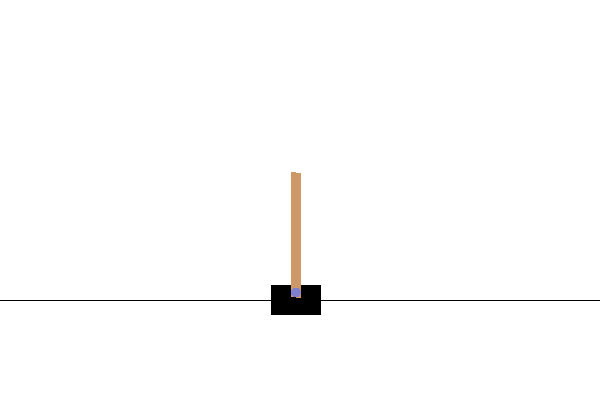

In [24]:
env.reset()
PIL.Image.fromarray(env.render())

El programa instancia dos environments: uno de entrenamiento y otro de evaluación.

In [25]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

El environment del CartPole, como la mayoria de los environments, esta escrito puramente en Python y es convertido a TF-Agents y TensorFlow usando la función **TFPyEnvironment**. El environment original usa Numpy arrays. La función **TFPyEnvironment** convierte estos arrays a **Tensors** para hacerlo compatible con los Tensorflow agents y policies.

In [26]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

##DQN
Solo se puede utilizar un DQN agent en environments en donde se tiene un espacio de acción discreto. El DQN usa QNetwork, modelo de redes neuronales que aprenden a predecir Q-values (salida esperada) para todas las acciones, cuando se le da un estado del environment.

El siguiente codigo utiliza **tf_agents.networks.q_network** para crear un QNetwork, pasandole **observation_spec**, **action_spec**, y una tupla que describe el numero y el tamaño de las capas ocuktas de los modelos.

In [27]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(train_env.observation_spec(),train_env.action_spec(),fc_layer_params=fc_layer_params)

Now we use **tf_agents.agents.dqn.dqn_agent** to instantiate a **DqnAgent**. In addition to the **time_step_spec**, **action_spec** and the QNetwork, the agent constructor also requires an optimizer (in this case, **AdamOptimizer**), a loss function, and an integer step counter.

In [28]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Politicas

Una política define la forma en que un agente actúa en un entorno. Usualmente, la meta del aprendizaje por refuerzo es de entrenar el modelo hasta que la politica pueda reproducir la salida deseada.

En este ejemplo:

* El resultado deseado es mantener el poste equilibrado en posición vertical sobre el carro.

* La politica retorna una acción (derecha o izquierda) por cada `time_step` de observación. 

Agents contain two policies: 
El agente contiene dos politicas:

*  **agent.policy** -  El algoritmo usa esta politica principal para evaluación y desarrollo.
* **agent.collect_policy** - El algoritmo usa esta politica secundaria para recolección de data.

In [29]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

## Metrica y Evaluación.

La metrica más común para evaluar una politica es resultado promedio. El resultado es la suma de todas las recompensas obtenidas utilizando una politica en un environment por un episodio. Varios episodios se corren, creando así un promedio con los resultados. La siguiente función calcula el resultado promedio para una politica, dandole la politica, el environment y los numeros de episodios. 

In [30]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

## Bufer de reproducción.


El búfer de reproducción realiza un seguimiento de los datos recopilados del entorno. Este tutorial usa **TFUniformReplayBuffer**. El constructor requiere las especificaciones de los datos que recopilará. Este valor está disponible en el agente mediante el método **collect_data_spec**. También se requieren el tamaño del lote y la longitud máxima del búfer.


In [31]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

Para la mayoría de los agentes, **collect_data_spec** es una tupla con nombre llamada **Trayectoria**, que contiene las especificaciones de observaciones, acciones, recompensas y otros elementos.


In [32]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

## Data Collection


In [34]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

#collect_data(train_env, random_policy, replay_buffer, steps=100)

In [36]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [37]:
iterator = iter(dataset)

print(iterator)

## Training the agent

Deben suceder dos cosas durante el ciclo de entrenamiento:

* Recopilar datos del medio ambiente.
* Use esos datos para entrenar las redes neuronales del agente

Este ejemplo también evalúa periódicamente la política e imprime la puntuación actual.

Lo siguiente tardará ~ 5 minutos en ejecutarse.

In [38]:
# (Optional) Optimize by wrapping some of the code in a graph 
# using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, \
                                num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, \
                                    num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 9.240323066711426
step = 400: loss = 3.028635025024414
step = 600: loss = 5.563343048095703
step = 800: loss = 18.009260177612305
step = 1000: loss = 6.115508556365967
step = 1000: Average Return = 68.5999984741211
step = 1200: loss = 23.400758743286133
step = 1400: loss = 24.29511260986328
step = 1600: loss = 2.2932446002960205
step = 1800: loss = 69.1056137084961
step = 2000: loss = 115.39750671386719
step = 2000: Average Return = 17.299999237060547
step = 2200: loss = 53.00029754638672
step = 2400: loss = 49.93019104003906
step = 2600: loss = 30.900184631347656
step = 2800: loss = 5.145997047424316
step = 3000: loss = 49.382720947265625
step = 3000: Average Return = 44.70000076293945
step = 3200: loss = 62.03211975097656
step = 3400: 

##Visualización

(8.164999198913574, 250.0)

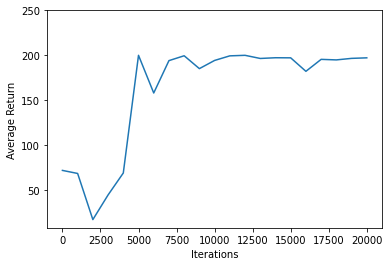

In [39]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

##Video



In [40]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [41]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")